# 🧠 Scientific Paper Topic Classification – Notebook Plan

## ✅ 1. Load and Explore the Dataset (EDA)
- [*] Load arXiv metadata.
- [*] Check dataset shape and column types.
- [*] Analyze class distribution.
- [*] Plot class frequencies (bar chart).
- [*] Check for missing values or duplicates.

---

## ✅ 2. Data Visualization
- [*] Plot class distribution.
- [*] Plot histogram of abstract lengths.
- [*] (Optional) Generate WordCloud for common words.
- [*] (Optional) Use t-SNE or PCA for class clusters.

---

## ✅ 3. Text Preprocessing
- [*] Remove rows with empty or missing text.
- [*] Convert text to lowercase.
---

## ✅ 4. Encode Labels
- [*] Use `LabelEncoder` to convert category names to numeric labels.
- [*] Save mappings (label2id and id2label).

---

## ✅ 5. Dataset Splitting
- [*] Split into train and test sets (stratified).

---

## ✅ 6. Tokenization with DistilBert
- [*] Load `AutoTokenizer` from `distilbert-base-uncased`.
- [*] Tokenize texts with truncation, padding, max_length=512.
- [*] Use Hugging Face `datasets.Dataset` and apply `.map()` for tokenization.

---

## ✅ 7. Load DistilBert Model
- [*] Load `AutoModelForSequenceClassification` with `num_labels = n_classes`.
- [*] Pass label2id and id2label in model config.

---

## ✅ 8. Define Training Configuration
- [*] Set up `TrainingArguments` (batch size, epochs, eval strategy, etc).
- [*] Initialize `Trainer` with model, tokenizer, datasets.
- [*] Add metric functions (accuracy, f1).

---

## ✅ 9. Train the Model
- [*] Train the model using `.train()`.
- [*] Save model checkpoints.
- [*] Save logs and metrics.

---

## ✅ 10. Evaluate the Model
- [*] Predict on validation set.
- [*] Compute classification metrics: accuracy, precision, recall, F1.
- [*] Display classification report.
- [*] Plot confusion matrix.

---

## ✅ 11. Save the Model & Tokenizer
- [*] Save model weights with `model.save_pretrained()`.
- [*] Save tokenizer with `tokenizer.save_pretrained()`.
- [*] Save label encoder or class mappings (JSON/pickle).

---

## ✅ 12. Inference on New Abstracts
- [*] Tokenize new abstract/title text.
- [*] Run model prediction.
- [*] Convert predicted label ID to class name using `id2label`.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
dataset = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"

In [3]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")

GPU Available: True
GPU Name: Tesla T4


In [4]:
import ujson as json
import pandas as pd
from collections import defaultdict
import random

# Set random seed for reproducibility
random.seed(42)

# Threshold
MIN_CLASS_SIZE = 100

# Categories we are interested in
categories_to_keep = ['cs.', 'stat.', 'math.', 'eess.']

# Dictionary to store lines by category
class_lines = defaultdict(list)

# First pass: Read and organize data by category
with open(dataset, 'r') as f:
    for line in f:
        try:
            record = json.loads(line)
            category = record['categories']
            
            # Check if the category starts with one of the desired prefixes
            if any(category.startswith(prefix) for prefix in categories_to_keep):
                class_lines[category].append(line)
        except (KeyError, ValueError) as e:
            print(f"Skipping record due to error: {e}")
            continue

# Second pass: For each category, sample 30% (if class is not too small)
sampled_lines = []
for cls, lines in class_lines.items():
    total_class = len(lines)
    
    # Skip categories that are too small (below a minimum size)
    if total_class < MIN_CLASS_SIZE:
        continue  

    # Taking all CS documents
    if cls.startswith("cs."):
        sampled_lines.extend(lines)
        continue  # to prevent sampling for cs. categories

    # Sample 10% for other categories
    sample_size = int(total_class * 0.30)  # Taking 30% for categories other than CS
    sampled = random.sample(lines, sample_size)
    sampled_lines.extend(sampled)

# Create DataFrame from the sampled lines
arxiv_df = pd.DataFrame([json.loads(line) for line in sampled_lines])

# Show final class distribution
print("\nFinal class distribution:")
print(arxiv_df['categories'].value_counts())


Final class distribution:
categories
cs.CV                      72430
cs.CL                      31243
cs.IT math.IT              23730
cs.LG                      23017
cs.LG stat.ML              15669
                           ...  
math.NA cs.MS cs.NA           30
math.OC cs.DC                 30
math.OC math-ph math.MP       30
math.RT math.AG math.CO       30
math.RA math.NT               30
Name: count, Length: 919, dtype: int64


In [5]:
cs_count = sum(len(lines) for cls, lines in class_lines.items() if cls.startswith("cs."))
print(f"\nTotal lines from cs.* classes: {cs_count}")
print(f"Total lines in final dataset: {len(sampled_lines)}")


Total lines from cs.* classes: 626277
Total lines in final dataset: 695633


In [6]:
df = arxiv_df.sample(frac=1, random_state=42)  
df.head(10)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
387530,2401.14624,Zhaoye Fei,"Zhaoye Fei, Yunfan Shao, Linyang Li, Zhiyuan Z...",Unearthing Large Scale Domain-Specific Knowled...,We have released the full data (total of 735GB...,None,None,None,cs.CL,http://creativecommons.org/licenses/by/4.0/,Large language models (LLMs) have demonstrated...,"[{'version': 'v1', 'created': 'Fri, 26 Jan 202...",2025-05-27,"[[Fei, Zhaoye, ], [Shao, Yunfan, ], [Li, Linya..."
48797,0805.4801,Teodor Banica,"Teodor Banica, Roland Vergnioux",Fusion rules for quantum reflection groups,33 pages,"J. Noncommut. Geom. 3 (2009), 327-359",None,None,math.OA,http://arxiv.org/licenses/nonexclusive-distrib...,We find the fusion rules for the quantum ana...,"[{'version': 'v1', 'created': 'Fri, 30 May 200...",2009-06-13,"[[Banica, Teodor, ], [Vergnioux, Roland, ]]"
49429,1403.6788,Wei Zhang,Wei Zhang,Tracial state space with non-compact extreme b...,arXiv admin note: substantial text overlap wit...,None,None,None,math.OA,http://creativecommons.org/licenses/by-nc-sa/3.0/,Let A be a unital simple separable C*-algebr...,"[{'version': 'v1', 'created': 'Wed, 26 Mar 201...",2014-06-30,"[[Zhang, Wei, ]]"
329254,2311.00998,Lucky Susanto,"Lucky Susanto, Ryandito Diandaru, Adila Krisna...",Replicable Benchmarking of Neural Machine Tran...,"Accepted on SEALP 2023, Workshop in IJCNLP-AAC...",None,None,None,cs.CL cs.AI,http://creativecommons.org/licenses/by/4.0/,Neural machine translation (NMT) for low-res...,"[{'version': 'v1', 'created': 'Thu, 2 Nov 2023...",2023-11-03,"[[Susanto, Lucky, ], [Diandaru, Ryandito, ], [..."
641477,2410.11875,Sudeep Pasricha,"Sirui Qi, Hayden Moore, Ninad Hogade, Dejan Mi...","A Framework for SLO, Carbon, and Wastewater-Aw...",None,None,None,None,cs.DC cs.AI cs.LG,http://creativecommons.org/licenses/by-nc-nd/4.0/,Function-as-a-Service (FaaS) is a growing cl...,"[{'version': 'v1', 'created': 'Wed, 9 Oct 2024...",2024-10-17,"[[Qi, Sirui, ], [Moore, Hayden, ], [Hogade, Ni..."
365177,2409.06178,Yuan Tian,"Yuan Tian, Jonathan K. Kummerfeld, Toby Jia-Ju...",SQLucid: Grounding Natural Language Database Q...,Accepted to UIST'24,None,None,None,cs.HC cs.CL,http://creativecommons.org/licenses/by/4.0/,Though recent advances in machine learning h...,"[{'version': 'v1', 'created': 'Tue, 10 Sep 202...",2024-09-11,"[[Tian, Yuan, ], [Kummerfeld, Jonathan K., ], ..."
410385,1805.01647,Sergey Pyatovsky,S.E.Pyatovsky,Business Processes of High-Tech Enterprises,None,Journal of Economy and entrepreneurship 4 (93)...,None,None,cs.CY,http://arxiv.org/licenses/nonexclusive-distrib...,This paper analyzes the results of Russia's ...,"[{'version': 'v1', 'created': 'Fri, 4 May 2018...",2018-05-07,"[[Pyatovsky, S. E., ]]"
690174,2501.09357,Manh Duong Phung,"Van Truong Hoang, Manh Duong Phung",Path Planning for a UAV Swarm Using Formation ...,in Proceedings of the 2025 International Confe...,None,None,None,cs.RO cs.SY eess.SY,http://creativecommons.org/licenses/by/4.0/,This work addresses the path planning proble...,"[{'version': 'v1', 'created': 'Thu, 16 Jan 202...",2025-01-17,"[[Hoang, Van Truong, ], [Phung, Manh Duong, ]]"
58125,2205.13806,Vicente Cort\'es,V. Cort\'es,"A note on quaternionic K\""ahler manifolds with...",None,None,None,None,math.DG,http://arxiv.org/licenses/nonexclusive-distrib...,We prove that complete non-locally symmetric...,"[{'version': 'v1', 'created': 'Fri, 27 May 202...",2022-05-30,"[[Cortés, V., ]]"
626398,2205.10490,Xiang Xiang,"Jing Ma, Xiang Xiang, Ke Wang, Yuchuan Wu, Yon...",Aligning Logits Generatively for Principled Bl...,To appear at CVPR 2024; significantly rewritte...,None,None,None,cs.LG cs.AI cs.CV stat.ML,http://arxiv.org/licenses/nonexclusive-distrib...,Black-Box Knowledge Distillation (B2KD) is a...,"[{'version': 'v1', 'created': 'Sat, 21 May 202...",2024-04-02,"[[Ma, Jing, ], [Xiang, Xiang, ], [Wang, Ke, ],..."


In [7]:
df.drop(columns=['journal-ref', 'doi','report-no','comments','submitter','license', 'versions','authors','update_date','authors_parsed'], inplace=True)

df.dropna(inplace=True)
print(len(df))


695633


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


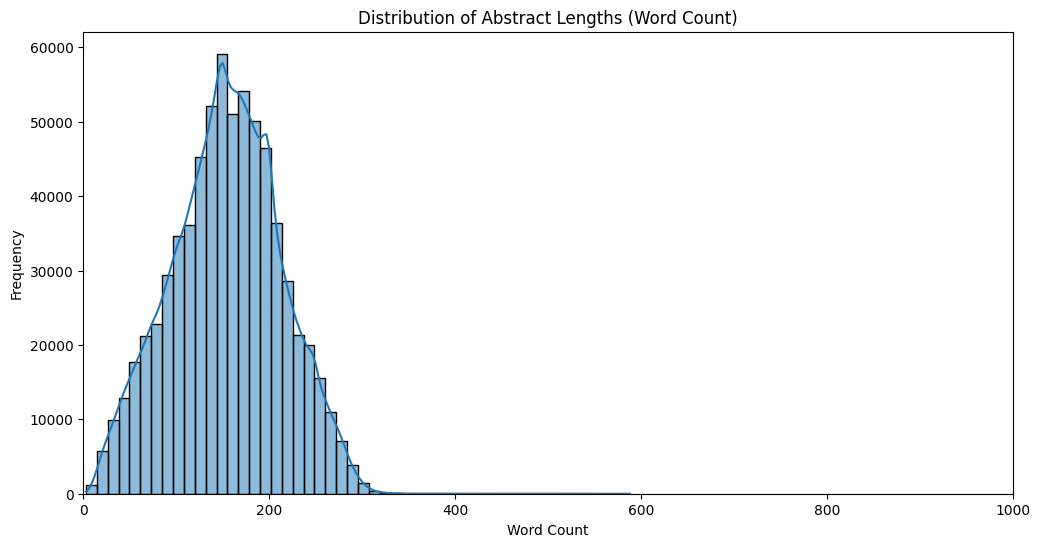

count    695633.000000
mean        154.337127
std          58.651718
min           3.000000
25%         114.000000
50%         155.000000
75%         195.000000
max         588.000000
Name: abstract_length, dtype: float64


In [8]:
df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df["abstract_length"], bins=50, kde=True)
plt.title("Distribution of Abstract Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xlim(0, 1000) # Limit x-axis for better visualization
plt.show()

print(df["abstract_length"].describe())

In [9]:
df.head()

,id,title,categories,abstract,abstract_length
387530,2401.14624,Unearthing Large Scale Domain-Specific Knowled...,cs.CL,Large language models (LLMs) have demonstrated...,168
48797,0805.4801,Fusion rules for quantum reflection groups,math.OA,We find the fusion rules for the quantum ana...,49
49429,1403.6788,Tracial state space with non-compact extreme b...,math.OA,Let A be a unital simple separable C*-algebr...,126
329254,2311.00998,Replicable Benchmarking of Neural Machine Tran...,cs.CL cs.AI,Neural machine translation (NMT) for low-res...,127
641477,2410.11875,"A Framework for SLO, Carbon, and Wastewater-Aw...",cs.DC cs.AI cs.LG,Function-as-a-Service (FaaS) is a growing cl...,95


In [10]:
max_len = df['abstract_length'].max()
max_len

588

In [11]:
     cat_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language "Natural Language Processing"',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'eess.SY': 'Systems and Control',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                 'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

In [12]:
df["category_name"]= df["categories"].map(cat_map)
df.head()

,id,title,categories,abstract,abstract_length,category_name
387530,2401.14624,Unearthing Large Scale Domain-Specific Knowled...,cs.CL,Large language models (LLMs) have demonstrated...,168,"Computation and Language ""Natural Language Pro..."
48797,0805.4801,Fusion rules for quantum reflection groups,math.OA,We find the fusion rules for the quantum ana...,49,Operator Algebras
49429,1403.6788,Tracial state space with non-compact extreme b...,math.OA,Let A be a unital simple separable C*-algebr...,126,Operator Algebras
329254,2311.00998,Replicable Benchmarking of Neural Machine Tran...,cs.CL cs.AI,Neural machine translation (NMT) for low-res...,127,NaN
641477,2410.11875,"A Framework for SLO, Carbon, and Wastewater-Aw...",cs.DC cs.AI cs.LG,Function-as-a-Service (FaaS) is a growing cl...,95,NaN


In [13]:
df.dropna(inplace=True)
print(len(df))
df.head()

376023


,id,title,categories,abstract,abstract_length,category_name
387530,2401.14624,Unearthing Large Scale Domain-Specific Knowled...,cs.CL,Large language models (LLMs) have demonstrated...,168,"Computation and Language ""Natural Language Pro..."
48797,0805.4801,Fusion rules for quantum reflection groups,math.OA,We find the fusion rules for the quantum ana...,49,Operator Algebras
49429,1403.6788,Tracial state space with non-compact extreme b...,math.OA,Let A be a unital simple separable C*-algebr...,126,Operator Algebras
410385,1805.01647,Business Processes of High-Tech Enterprises,cs.CY,This paper analyzes the results of Russia's ...,150,Computers and Society
58125,2205.13806,"A note on quaternionic K\""ahler manifolds with...",math.DG,We prove that complete non-locally symmetric...,21,Differential Geometry


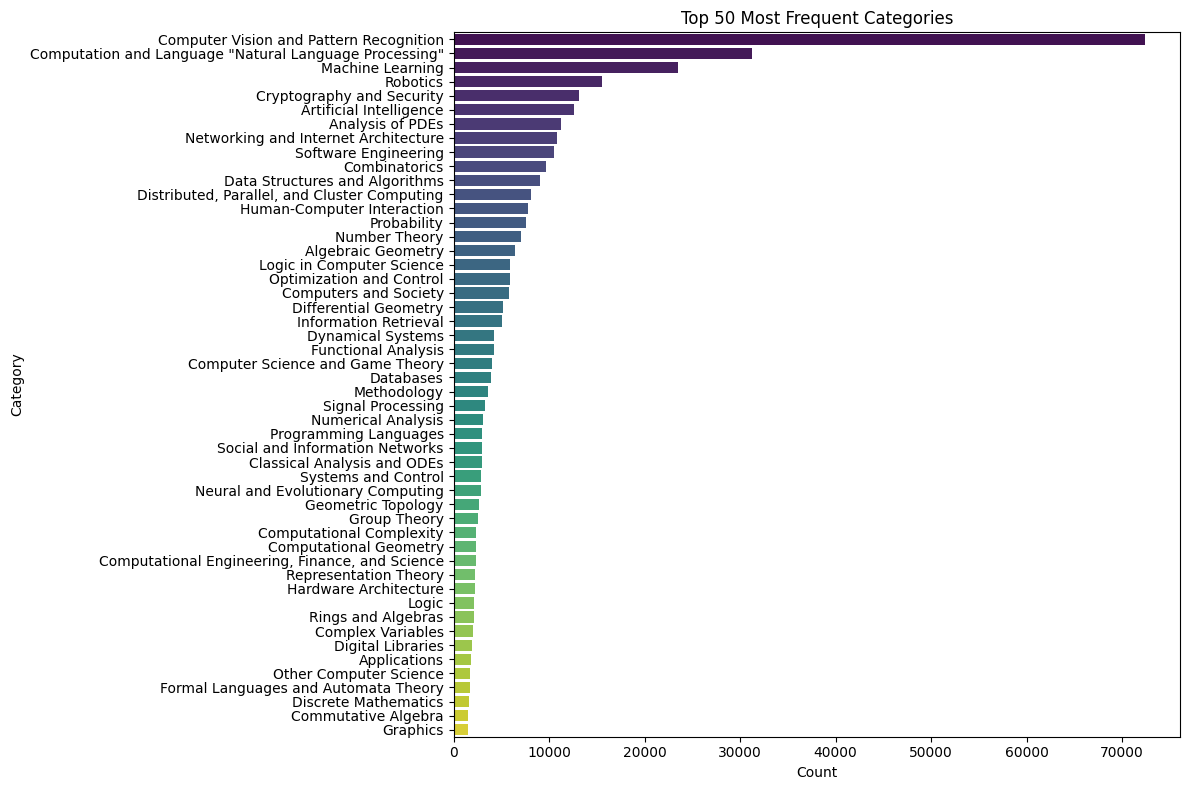

In [14]:
top_n = 50  
top_categories = df['category_name'].value_counts().nlargest(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title(f"Top {top_n} Most Frequent Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


In [15]:
top_categories_to_keep = df['category_name'].value_counts().nlargest(35).index
df = df[df["category_name"].isin(top_categories_to_keep)]

In [16]:
len(df)

330905

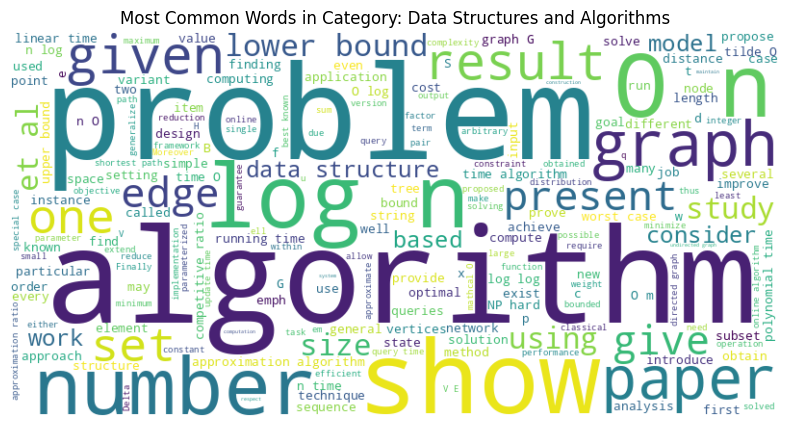

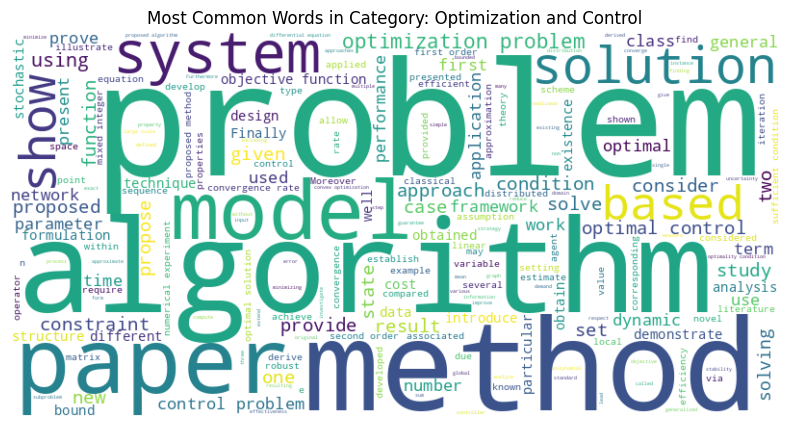

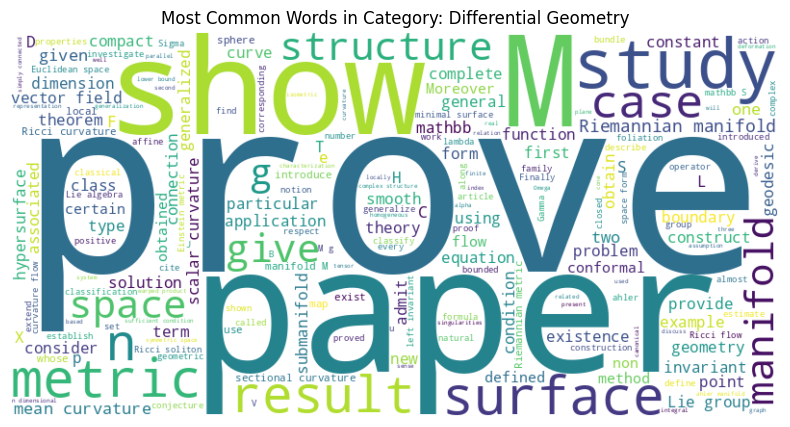

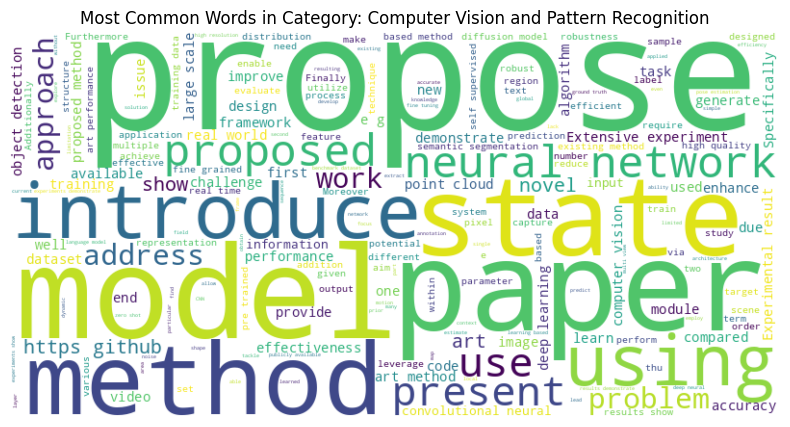

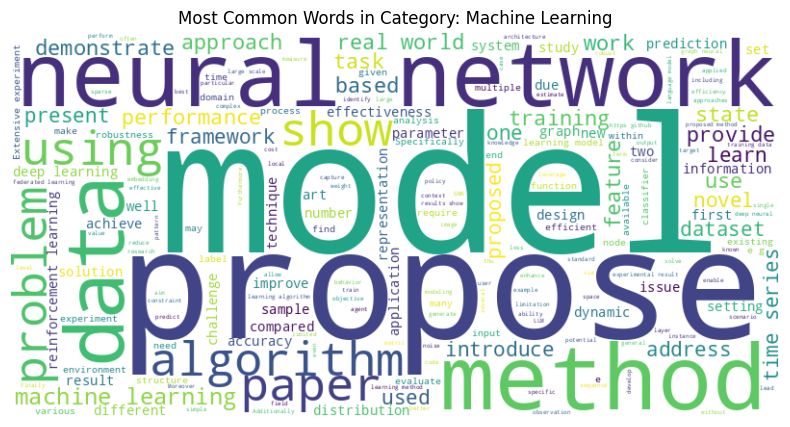

In [17]:
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sampled_labels = random.sample(list(df['category_name'].unique()), 5)

for label in sampled_labels:
    text = " ".join(df[df['category_name'] == label]['abstract'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in Category: {label}')
    plt.show()


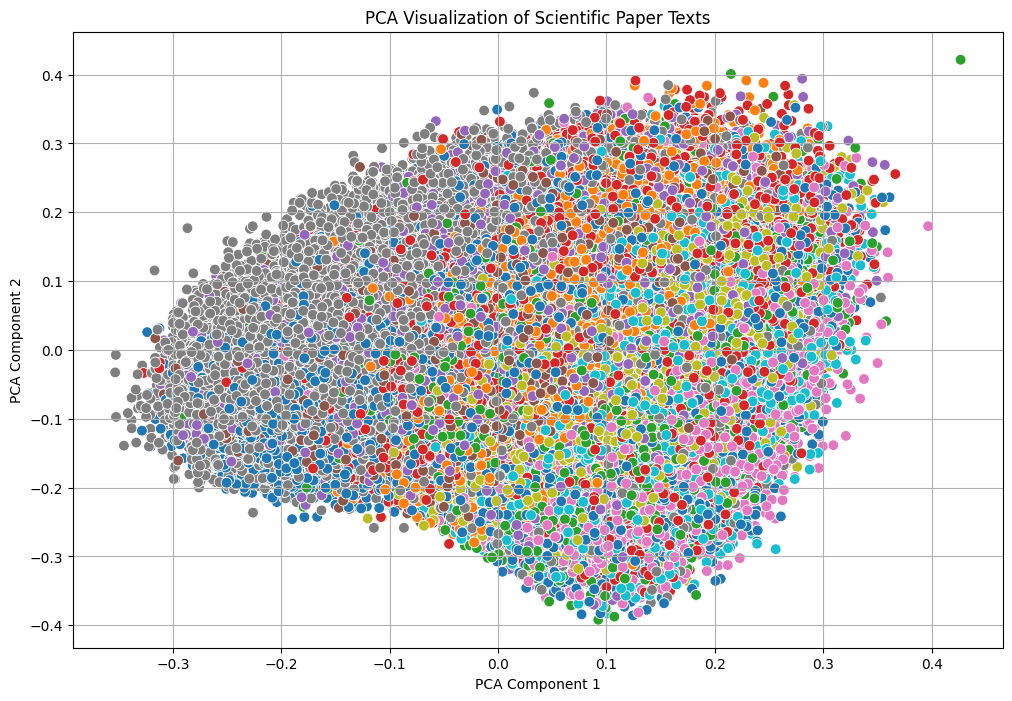

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['abstract']) 

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())


plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['category_name'], palette='tab10', s=60, legend=False)
plt.title('PCA Visualization of Scientific Paper Texts')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


In [19]:
df = df.copy() 

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["category_name"])

label2id = {label: int(idx) for idx, label in enumerate(label_encoder.classes_)}
id2label = {v: k for k, v in label2id.items()}

df[["category_name", "label"]].drop_duplicates().sort_values(by="label")

,category_name,label
44299,Algebraic Geometry,0
97457,Analysis of PDEs,1
264857,Artificial Intelligence,2
147844,Classical Analysis and ODEs,3
6581,Combinatorics,4
387530,"Computation and Language ""Natural Language Pro...",5
403645,Computer Science and Game Theory,6
191551,Computer Vision and Pattern Recognition,7
410385,Computers and Society,8
131528,Cryptography and Security,9


In [20]:
min_samples_per_category = 100 
category_counts = df["category_name"].value_counts()
if not category_counts.empty:
    # Get categories that meet the threshold
    categories_to_keep = category_counts[category_counts >= min_samples_per_category].index.tolist()
    print(f"Keeping {len(categories_to_keep)} categories with at least {min_samples_per_category} samples.")

    # Filter the DataFrame
    df = df[df["category_name"].isin(categories_to_keep)].copy()
    print(f"Dataset shape after filtering categories: {df.shape}")


Keeping 35 categories with at least 100 samples.
Dataset shape after filtering categories: (330905, 7)


In [21]:
train_df, test_df = train_test_split(df, test_size=0.2,stratify=df['label'], random_state=42)
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 264724
Testing samples: 66181


In [22]:
import pandas as pd

train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)


In [23]:
import torch

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

if device.type == 'cuda':
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB')
else:
    print("No GPU detected. Model will run on CPU (which will be significantly slower).")

Using device: cuda
GPU Name: Tesla T4
GPU Memory Total: 14.74 GB


In [24]:
import datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType

base_model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

def tokenize_function(example):
    return tokenizer(example['abstract'], truncation=True, padding='max_length', max_length=256)

train_dataset = datasets.Dataset.from_pandas(train_df[['category_name', 'abstract', 'label']])
test_dataset = datasets.Dataset.from_pandas(test_df[['category_name', 'abstract', 'label']])

train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/264724 [00:00<?, ? examples/s]

Map:   0%|          | 0/66181 [00:00<?, ? examples/s]

In [25]:
train_dataset_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


device = "cuda" if torch.cuda.is_available() else "cpu"


from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset_tokenized, batch_size=16)
test_dataloader = DataLoader(test_dataset_tokenized, batch_size=16)


for batch in train_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    print(f"Device: {input_ids.device}")  
    break  


Device: cuda:0


In [26]:
from peft import LoraConfig, get_peft_model, TaskType

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


# LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    inference_mode=False,
    target_modules=["q_lin", "v_lin"],  
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)


model = get_peft_model(model, lora_config)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=76

In [27]:
print("Model device:", next(model.parameters()).device)  # Should output: `cuda:0`
print("GPU memory allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")

Model device: cuda:0
GPU memory allocated: 259.57568359375 MB


In [28]:
# Define compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate metrics, use 'weighted' average for imbalanced classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [29]:
from transformers import  Trainer, TrainingArguments
import os 


use_fp16 = torch.cuda.is_available()
output_dir = '/kaggle/working/results'
logging_dir = './logs'

training_args = TrainingArguments(
    output_dir=output_dir,               # output directory for model checkpoints and predictions
    num_train_epochs=3,                  # total number of training epochs (start with 1-3, tune later)
    per_device_train_batch_size=16,       # batch size per device during training (adjust based on GPU memory, e.g., 8, 16)
    per_device_eval_batch_size=32,       # batch size for evaluation
    gradient_accumulation_steps=1,       # Simulate larger batch size (8*2=16 effective)
    learning_rate=1e-4,                  # Learning rate (common for fine-tuning BERT-like models)
    warmup_steps=100,                    # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # strength of weight decay (regularization)
    logging_dir=logging_dir,             # directory for storing logs
    logging_strategy="steps",           # Log metrics every 'logging_steps'
    logging_steps=500,                   # log metrics every X steps
    evaluation_strategy="steps",         # evaluate every `eval_steps`
    eval_steps=2000,                      # evaluate every X steps (adjust based on dataset size)
    save_strategy="steps",               # save checkpoint every `save_steps`
    save_steps=2000,                      # save checkpoint every X steps
    save_total_limit=2,
    load_best_model_at_end=True,         # load the best model found during training at the end
    metric_for_best_model="f1",          # use f1 score to determine the best model
    greater_is_better=True,              # higher f1 is better
    fp16=use_fp16,                       # Enable mixed precision training if GPU supports it
    report_to="none"                   # Disable external reporting (like wandb/tensorboard) for simplicity
)

resume_from_checkpoint = None
if os.path.isdir(output_dir):
    checkpoints = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))
        resume_from_checkpoint = checkpoints[-1]  


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized, # Use tokenized HF dataset
    eval_dataset=test_dataset_tokenized,   # Use tokenized HF dataset
    compute_metrics=compute_metrics,
    tokenizer=tokenizer # Pass tokenizer for padding consistency if needed by Trainer internally
)
print('Trainer initialized.')

Trainer initialized.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-29-4797623c461e>:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
# Start Training
# print("Starting training... If a checkpoint exists, it will be used to resume.")
try:
    train_result = trainer.train(resume_from_checkpoint=resume_from_checkpoint)
    print("Training finished successfully.")
    
    # Log and save training metrics
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()  # Save trainer state including args, optimizer, scheduler
    print(f"Training metrics saved to {training_args.output_dir}")
except Exception as e:
    print(f"An error occurred during training: {e}")
    # Consider logging the error or raising it depending on the workflow

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss


Training finished successfully.
***** train metrics *****
  epoch                    =          3.0
  total_flos               =   49886334GF
  train_loss               =          0.0
  train_runtime            =   0:00:00.01
  train_samples_per_second = 65587626.682
  train_steps_per_second   =  2049706.243
Training metrics saved to /kaggle/working/results


In [31]:
# Evaluate the trained model on the validation set
print("Evaluating the model on the validation set...")
try:
    eval_metrics = trainer.evaluate()
    print("Evaluation Results:")
    # Pretty print the evaluation results
    for key, value in eval_metrics.items():
        print(f'{key}: {value:.4f}')

    # Log and save evaluation metrics
    trainer.log_metrics("eval", eval_metrics)
    trainer.save_metrics("eval", eval_metrics)
    print(f"Evaluation metrics saved to {training_args.output_dir}")
except Exception as e:
    print(f"An error occurred during evaluation: {e}")

Evaluating the model on the validation set...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results:
eval_loss: 0.5854
eval_accuracy: 0.8147
eval_f1: 0.8121
eval_precision: 0.8111
eval_recall: 0.8147
eval_runtime: 275.3186
eval_samples_per_second: 240.3800
eval_steps_per_second: 3.7590
epoch: 3.0000
***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.8147
  eval_f1                 =     0.8121
  eval_loss               =     0.5854
  eval_precision          =     0.8111
  eval_recall             =     0.8147
  eval_runtime            = 0:04:35.31
  eval_samples_per_second =     240.38
  eval_steps_per_second   =      3.759
Evaluation metrics saved to /kaggle/working/results


In [32]:
# Get all the logs from training
logs = trainer.state.log_history

eval_logs = [log for log in logs if 'eval_loss' in log]


df_logs = pd.DataFrame(eval_logs)

df_logs = df_logs.sort_values(by='step')

print(df_logs[['step', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']])


     step  eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall
0    2000   0.783745       0.755081  0.752610        0.755598     0.755081
1    4000   0.713047       0.775011  0.771803        0.775704     0.775011
2    6000   0.674938       0.789124  0.784306        0.785238     0.789124
3    8000   0.651496       0.793974  0.791745        0.792336     0.793974
4   10000   0.647174       0.795455  0.794673        0.797290     0.795455
5   12000   0.622297       0.803221  0.799762        0.799466     0.803221
6   14000   0.616351       0.805020  0.802985        0.804107     0.805020
7   16000   0.603346       0.808344  0.805962        0.806769     0.808344
8   18000   0.596740       0.811351  0.809007        0.808450     0.811351
9   20000   0.595785       0.812121  0.809593        0.809793     0.812121
10  22000   0.589737       0.813179  0.810810        0.810997     0.813179
11  24000   0.585375       0.814705  0.812081        0.811147     0.814705
12  24819   0.585375     

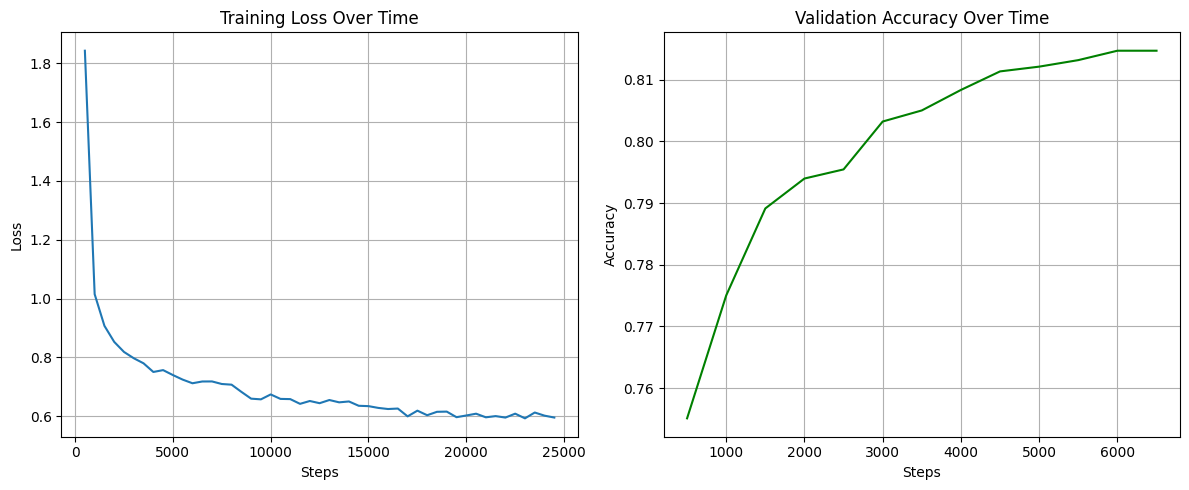

In [33]:
import matplotlib.pyplot as plt

def plot_training_history(trainer_state):
    steps = [log['step'] for log in trainer_state.log_history if 'loss' in log]
    loss = [log['loss'] for log in trainer_state.log_history if 'loss' in log]
    acc = [log.get('eval_accuracy') for log in trainer_state.log_history if 'eval_accuracy' in log]

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(steps, loss, label='Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(steps[:len(acc)], acc, label='Accuracy', color='green')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(trainer.state)


In [34]:
# Optional: Save the fine-tuned model and tokenizer for later use

import pickle

save_directory = './fine_tuned_DistilBert_with_LoRA'
try:
    trainer.save_model(save_directory)
    # tokenizer.save_pretrained(save_directory) # Already passed to trainer, should be saved with model state
    print(f"Model saved to {save_directory}")
    # Save label encoder and maps again in the same directory for completeness
    with open(os.path.join(save_directory, 'label_encoder.pkl'), 'wb') as le_file:
        pickle.dump(label_encoder, le_file)

    # Save label maps
    with open(os.path.join(save_directory, 'label_map.json'), 'w') as lm_file:
        json.dump(
            {
                "id2label": id2label,
                "label2id": label2id
            },
            lm_file,
            indent=4
        )
    print(f"Label encoder and map also saved in {save_directory}")
except Exception as e:
    print(f"Error saving model/tokenizer/labels: {e}")

Model saved to ./fine_tuned_DistilBert_with_LoRA
Label encoder and map also saved in ./fine_tuned_DistilBert_with_LoRA


In [35]:
import shutil
import os

save_directory = './fine_tuned_DistilBert_With_LoRA'
zip_filename = save_directory + '.zip'

try:
    # Delete the zip file if it already exists (to avoid overwrite issues)
    if os.path.exists(zip_filename):
        os.remove(zip_filename)
    
    # Make ZIP file from folder
    shutil.make_archive(save_directory, 'zip', save_directory)
    
    print(f"✅ Zipped model directory saved as: {zip_filename}")
except Exception as e:
    print(f"❌ Error while zipping the model folder: {e}")


✅ Zipped model directory saved as: ./fine_tuned_DistilBert_With_LoRA.zip


In [36]:
def predict_abstract_class(model, tokenizer, abstract, id2label, device='cuda'):
    model.eval()
    inputs = tokenizer(abstract, return_tensors='pt', truncation=True, padding=True).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class_id = torch.argmax(probs, dim=1).item()
        confidence = torch.max(probs).item()

    category_name = id2label[pred_class_id]
    return category_name, confidence


In [37]:
abstract = "Large Language Models (LLMs) have become foundational to modern AI agent systems, enabling autonomous agents to reason and plan. In most existing systems, inter-agent communication relies primarily on natural language. While this design supports interpretability and human oversight, we argue that it introduces fundamental limitations in agent-to-agent coordination. The semantic space of natural language is structurally misaligned with the high-dimensional vector spaces in which LLMs operate, resulting in information loss and behavioral drift. Beyond surface-level inefficiencies, we highlight a deeper architectural limitation: current LLMs were not trained with the objective of supporting agentic behavior. As such, they lack mechanisms for modeling role continuity, task boundaries, and multi-agent dependencies. The standard next-token prediction paradigm fails to support the structural alignment required for robust, scalable agent coordination. Based on this, we argue that two core questions deserve careful examination: first, given that AI agents fundamentally operate in high-dimensional vector spaces, should they rely on a language system originally designed for human cognition as their communication medium? Second, should we consider developing a new model construction paradigm that builds models from the ground up to natively support structured communication, shared intentionality, and task alignment in multi-role, multi-agent environments? This paper calls for a reconsideration not only of how agents should communicate, but also of what it fundamentally means to train a model that natively supports multi-agent coordination and communication"

predicted_class, conf = predict_abstract_class(model, tokenizer, abstract, id2label)

print(f"Predicted Class: {predicted_class} (Confidence: {conf:.2f})")


Predicted Class: Artificial Intelligence (Confidence: 0.89)


In [39]:
import os

save_directory = './fine_tuned_DistilBert_with_LoRA'


print(os.listdir(save_directory))


['tokenizer_config.json', 'adapter_model.safetensors', 'label_map.json', 'training_args.bin', 'vocab.txt', 'special_tokens_map.json', 'tokenizer.json', 'README.md', 'label_encoder.pkl', 'adapter_config.json']


**reloaded the model again because the session has been stopped**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

base_model_name = "distilbert-base-uncased"
save_path = "./base_model"

model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=35)  # عدّلي num_labels حسب عدد الفئات
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Base model saved locally to: {save_path}")


In [ ]:
from peft import PeftModel

lora_model = PeftModel.from_pretrained(model, "/kaggle/input/loraaaaa")

In [ ]:
merged_model = lora_model.merge_and_unload()
merged_model.save_pretrained("./merged_model")


In [9]:
import shutil

tokenizer_files = [
    "tokenizer_config.json",
    "tokenizer.json",
    "vocab.txt",
    "special_tokens_map.json"
]

for file in tokenizer_files:
    shutil.copy(f"/kaggle/input/loraaaaa/{file}", "./merged_model")



In [14]:
shutil.copy("/kaggle/input/loraaaaa/label_map.json", "./merged_model/")

'./merged_model/label_map.json'

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


model = AutoModelForSequenceClassification.from_pretrained("./merged_model")
tokenizer = AutoTokenizer.from_pretrained("./merged_model")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:

text = "Pure time series forecasting tasks typically focus exclusively on numerical features; however, real-world financial decision-making demands the comparison and analysis of heterogeneous sources of information. Recent advances in deep learning and large scale language models (LLMs) have made significant strides in capturing sentiment and other qualitative signals, thereby enhancing the accuracy of financial time series predictions. Despite these advances, most existing datasets consist solely of price series and news text, are confined to a single market, and remain limited in scale. In this paper, we introduce FinMultiTime, the first large scale, multimodal financial time series dataset. FinMultiTime temporally aligns four distinct modalities financial news, structured financial tables, K-line technical charts, and stock price time series across both the S&P 500 and HS 300 universes. Covering 5,105 stocks from 2009 to 2025 in the United States and China, the dataset totals 112.6 GB and provides minute-level, daily, and quarterly resolutions, thus capturing short, medium, and long term market signals with high fidelity. Our experiments demonstrate that (1) scale and data quality markedly boost prediction accuracy; (2) multimodal fusion yields moderate gains in Transformer models; and (3) a fully reproducible pipeline enables seamless dataset updates"

# Tokenize the input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)


In [17]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits


predicted_class_id = torch.argmax(logits, dim=1).item()
print(f"Predicted class ID: {predicted_class_id}")


Predicted class ID: 2


In [18]:
import json

with open("./merged_model/label_map.json", "r") as f:
    label_map = json.load(f)

id2label = label_map["id2label"]
print(f"Predicted label: {id2label[str(predicted_class_id)]}")


Predicted label: Artificial Intelligence


In [19]:
import shutil

shutil.make_archive("merged_model_final", 'zip', "./merged_model")


'/kaggle/working/merged_model_final.zip'

In [2]:
# import shutil
# import os

# save_path = "./base_model"
# zip_filename = save_path + '.zip'

# 
# if os.path.exists(zip_filename):
#     os.remove(zip_filename)

# 
# shutil.make_archive(save_path, 'zip', save_path)
# print(f"✅ Model zipped successfully: {zip_filename}")


✅ Model zipped successfully: ./base_model.zip


In [3]:
# from IPython.display import FileLink

# # zip_filename = '/kaggle/working/fine_tuned_model_with_lora.zip'
# FileLink(zip_filename)


/kaggle/working/base_model.zip